# Sprawozdanie z laboratorium 7

***Autor: Adam Dąbkowski***

Celem siódmego laboratorium jest zaimplementowanie naiwnego klasyfikatora Bayesa. Dodatkowo należy wykorzystać stworzony algorytm do stworzenia i zbadania jakości klasyfikatorów dla zbioru danych ***Cardio Vascular Disease Detection***. Doświadczenia mają zostać przeprowadzone, uwzględniając, zarówno różne podziały na zbiór trenujący, walidacyjny i testowy, jak i różne uruchomienia k-krotnej walidacji krzyżowej (z różnymi podziałami na zbiór treningowy+walidacyjny i testowy) w celu późniejszej oceny, która metoda pomiaru (zbiór walidacyjny czy walidacja krzyżowa) lepiej odzwierciedla wyniki na zbiorach testowych.


## 0. Importowanie niezbędnych bibliotek

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

## 1. Przygotowanie danych

Dane, na których będziemy testowali naszą implementację naiwnego klasyfikatora Bayesa, jest zbiór ***Cardio Vascular Disease Detection***. Jak widać na poniższym listingu, wśród cech znajduje się pole ***id***, które w trakcie uczenia modelu jest niepotrzebne.

In [69]:
data = pd.read_csv('./data/cardio_train.csv', sep=';')
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [70]:
data.drop(["id"], axis=1, inplace=True)

In [71]:
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0


W analizowanym przez nas zbiorze klasą jest pole ***cardio***. Mając to na uwadze, możemy podzielić nasze na dwa zbiory: zbiór ***X*** (przestrzeń wejść) i zbiór ***y*** (przestrzeń wyjść). Dodatkowo poprzez zastosowanie ***dropna*** usuwane są wiersze z brakującymi danymi.

In [72]:
data.dropna(inplace=True)

In [73]:
X = data.drop('cardio', axis=1)
y = data['cardio']

In [74]:
X.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,22469,1,155,69.0,130,80,2,2,0,0,1
1,14648,1,163,71.0,110,70,1,1,0,0,1
2,21901,1,165,70.0,120,80,1,1,0,0,1
3,14549,2,165,85.0,120,80,1,1,1,1,1
4,23393,1,155,62.0,120,80,1,1,0,0,1


In [75]:
X = X.values
y = y.values

## 2. Implementacja naiwnego klasyfikatora Bayesa

In [76]:
class NaiveBayesClassifier:
    def __init__(self):
        self.X = None
        self.y = None
        self.classes = None
        self.mean = None
        self.var = None
        self.priors = None

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes = np.unique(y)

        self.mean = np.zeros((len(self.classes), X.shape[1]))
        self.var = np.zeros((len(self.classes), X.shape[1]))
        self.priors = np.zeros(len(self.classes))

        for i, c in enumerate(self.classes):
            X_c = self.X[np.where(y == c)]
            self.mean[i, :] = X_c.mean(axis=0)
            self.var[i, :] = X_c.var(axis=0)
            self.priors[i] = X_c.shape[0] / X.shape[0]

    def calc_gaussian_probability(self, mean, var, x):
        var_eps = 1e-3
        return (1.0 / np.sqrt(2.0 * np.pi * var + var_eps)) * (np.exp(-((x - mean) ** 2 / (2 * var + var_eps))))

    def classify(self, x):
        posteriors = []

        for i, c in enumerate(self.classes):
            prior = self.priors[i]
            posterior = np.prod(self.calc_gaussian_probability(self.mean[i], self.var[i], x))

            posterior = posterior * prior
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        return [self.classify(x) for x in X]

## 3. Implementacja funkcji pomocniczych

Aby usprawnić analizę otrzymanych wyników, zaimplementowane zostały funkcje pomocnicze ***get_metrics()*** oraz ***plot_confusion_matrix()*** . Pierwsza z nich zwraca wyniki poszczególnych metryk takich jak: dokładność, precyzja, pełność i wynik $F_1$, druga natomiast wyznacza macierz pomyłek dla zbioru testowego.

In [77]:
def get_metrics(y_true, y_pred, printing=True):
    accuracy = round(metrics.accuracy_score(y_true, y_pred), 5)
    precision = round(metrics.precision_score(y_true, y_pred), 5)
    recall = round(metrics.recall_score(y_true, y_pred), 5)
    f1_score = round(metrics.f1_score(y_true, y_pred), 5)

    if printing:
        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1 score: ", f1_score)

    return [accuracy, precision, recall, f1_score]

In [78]:
def plot_confusion_matrix(y_true, y_pred, set_type="test"):
    cf_matrix = metrics.confusion_matrix(y_true, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, center=True, annot=labels, fmt="", cmap='viridis')
    plt.title(f"Confusion matrix for {set_type} set")
    plt.show()

In [79]:
class Results:
    def __init__(self):
        self.results = pd.DataFrame(columns=["Type", "Sets size (training|validation|test) / Folds number", "Accuracy", "Precision", "Recall", "F1 score"])

    def update_results(self, type, size, accuracy, precision, recall, f1_score):
        self.results.loc[len(self.results)] = [type, size, accuracy, precision, recall, f1_score]

    def delete_row(self, index):
        self.results.drop([index], axis=0, inplace=True)

    def sort_results(self, column_name):
        self.results = self.results.sort_values(by=[column_name])

    def __repr__(self):
        return self.results.to_string()

In [80]:
def simulate_standard(X, y, train_size=0.7):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=train_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

    bayes_clf = NaiveBayesClassifier()
    bayes_clf.fit(X_train, y_train)

    y_val_pred = bayes_clf.predict(X_val)
    get_metrics(y_val, y_val_pred)
    plot_confusion_matrix(y_val, y_val_pred, set_type="validation")

    y_test_pred = bayes_clf.predict(X_test)
    metrics_data = get_metrics(y_test, y_test_pred)
    plot_confusion_matrix(y_test, y_test_pred, set_type = "test")

    return metrics_data

In [81]:
def simulate_cross_validation(X, y, k=3):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    bayes_clf = NaiveBayesClassifier()

    metrics_data = []
    i = 1

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        print(f"Fold {i}:")

        bayes_clf.fit(X_train, y_train)
        y_pred = bayes_clf.predict(X_test)

        metrics_data.append(get_metrics(y_test, y_pred))
        plot_confusion_matrix(y_test, y_pred, set_type = "test")

        i += 1

    metrics_data = np.array(metrics_data)
    average_accuracy = round(np.mean(metrics_data[:, 0]), 5)
    average_precision = round(np.mean(metrics_data[:, 1]), 5)
    average_recall = round(np.mean(metrics_data[:, 2]), 5)
    average_f1_score = round(np.mean(metrics_data[:, 3]), 5)


    print(f"-------------------- Average results ({k} folds)  --------------------")
    print("Average accuracy:", average_accuracy)
    print("Average precision:", average_precision)
    print("Average recall:", average_recall)
    print("Average f1 score:", average_f1_score)

    return [average_accuracy, average_precision, average_recall, average_f1_score]

## 4. Zastosowanie klasyfikatora

#### 4.1 Podział na zbiór trenujący, walidacyjny i testowy

In [82]:
results_standard = Results()

Accuracy:  0.57633
Precision:  0.73087
Recall:  0.25165
F1 score:  0.37439


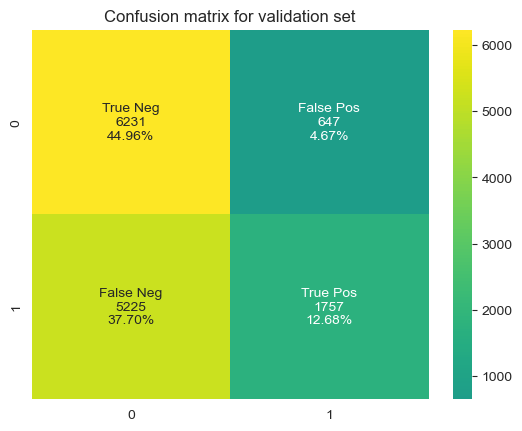

Accuracy:  0.57947
Precision:  0.72139
Recall:  0.25765
F1 score:  0.3797


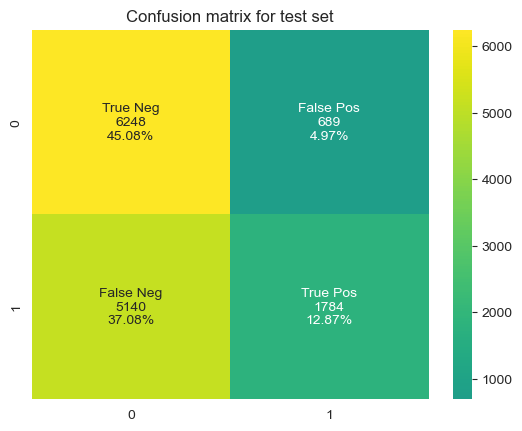

In [83]:
result = simulate_standard(X, y, train_size=0.6)

In [84]:
results_standard.update_results("Standard", "0,6  | 0,2   |   0,2", result[0], result[1], result[2], result[3])

Accuracy:  0.58461
Precision:  0.72203
Recall:  0.27449
F1 score:  0.39777


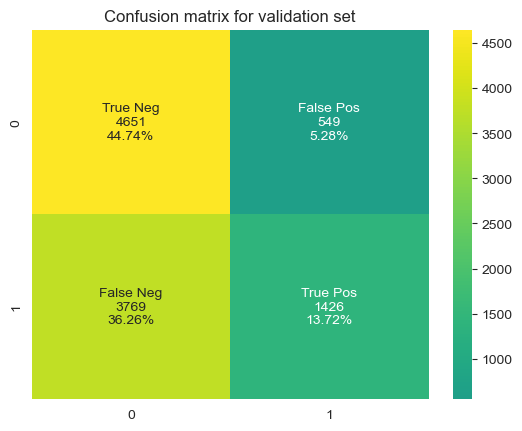

Accuracy:  0.58042
Precision:  0.7208
Recall:  0.26933
F1 score:  0.39214


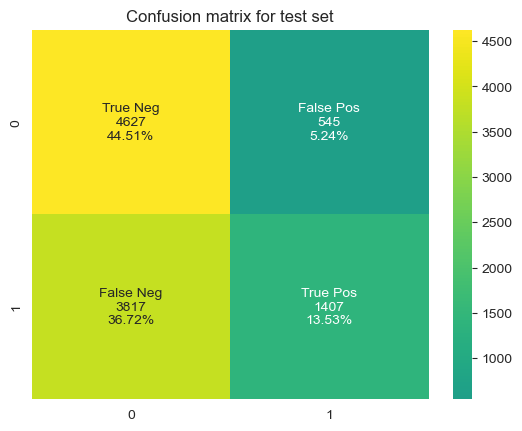

In [85]:
result = simulate_standard(X, y, train_size=0.7)

In [86]:
results_standard.update_results("Standard", "0,7  | 0,15  |  0,15", result[0], result[1], result[2], result[3])

Accuracy:  0.58211
Precision:  0.72339
Recall:  0.26822
F1 score:  0.39134


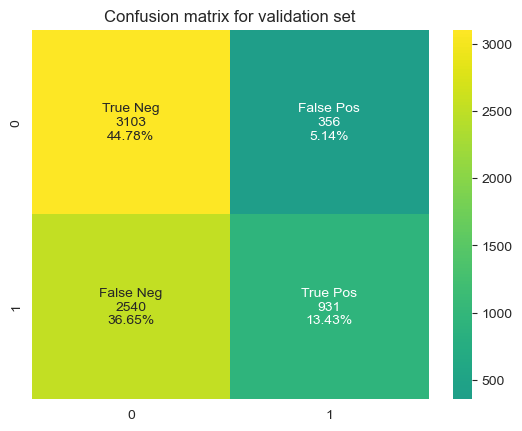

Accuracy:  0.58419
Precision:  0.7182
Recall:  0.27294
F1 score:  0.39555


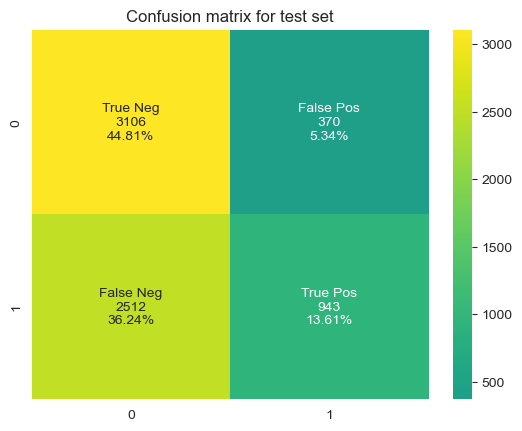

In [87]:
result = simulate_standard(X, y, train_size=0.8)

In [88]:
results_standard.update_results("Standard", "0,8  | 0,1   |   0,1", result[0], result[1], result[2], result[3])

Accuracy:  0.58788
Precision:  0.69467
Recall:  0.30291
F1 score:  0.42186


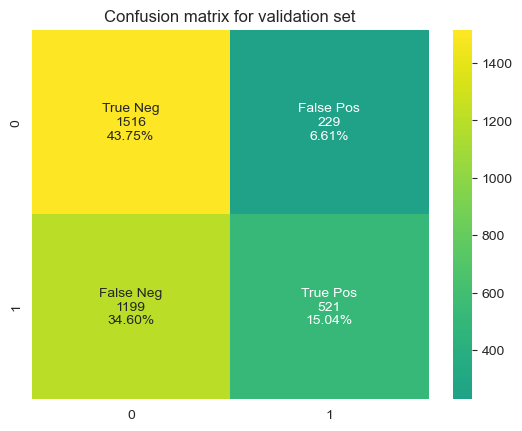

Accuracy:  0.58223
Precision:  0.69717
Recall:  0.29753
F1 score:  0.41707


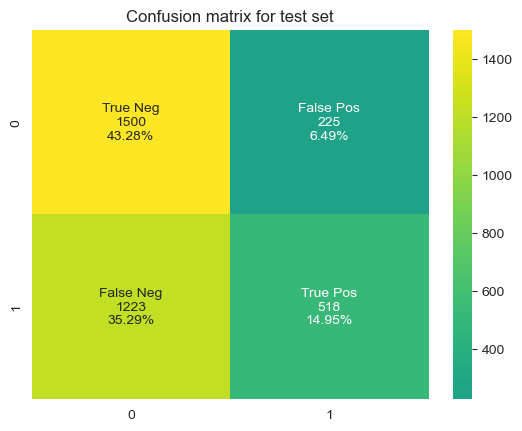

In [89]:
result = simulate_standard(X, y, train_size=0.9)

In [90]:
results_standard.update_results("Standard", "0,9  | 0,05  |  0,05", result[0], result[1], result[2], result[3])

Accuracy:  0.57703
Precision:  0.69713
Recall:  0.30204
F1 score:  0.42147


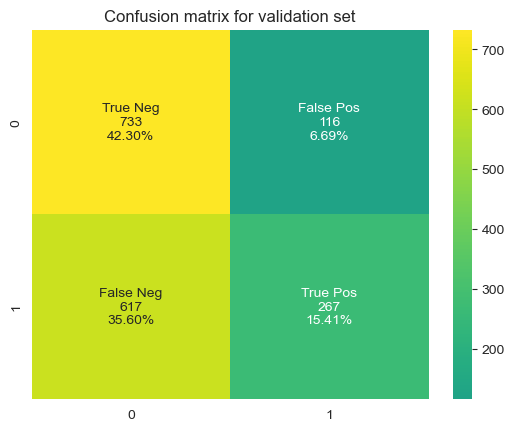

Accuracy:  0.58165
Precision:  0.70604
Recall:  0.30499
F1 score:  0.42597


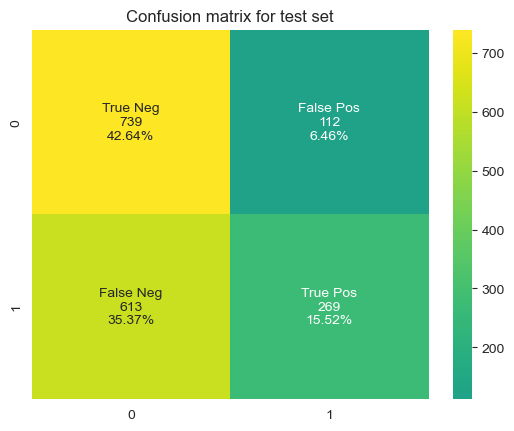

In [91]:
result = simulate_standard(X, y, train_size=0.95)

In [92]:
results_standard.update_results("Standard", "0,95 | 0,025 | 0,025", result[0], result[1], result[2], result[3])

In [93]:
results_standard.sort_results("Sets size (training|validation|test) / Folds number")
results_standard.results

,Type,Sets size (training|validation|test) / Folds number,Accuracy,Precision,Recall,F1 score
0,Standard,"0,6 | 0,2 | 0,2",0.57947,0.72139,0.25765,0.37970
1,Standard,"0,7 | 0,15 | 0,15",0.58042,0.72080,0.26933,0.39214
2,Standard,"0,8 | 0,1 | 0,1",0.58419,0.71820,0.27294,0.39555
3,Standard,"0,9 | 0,05 | 0,05",0.58223,0.69717,0.29753,0.41707
4,Standard,"0,95 | 0,025 | 0,025",0.58165,0.70604,0.30499,0.42597


#### 4.2 k-krotna walidacja krzyżowa

In [94]:
results_cross_validation = Results()

Fold 1:
Accuracy:  0.58006
Precision:  0.72548
Recall:  0.26545
F1 score:  0.38868


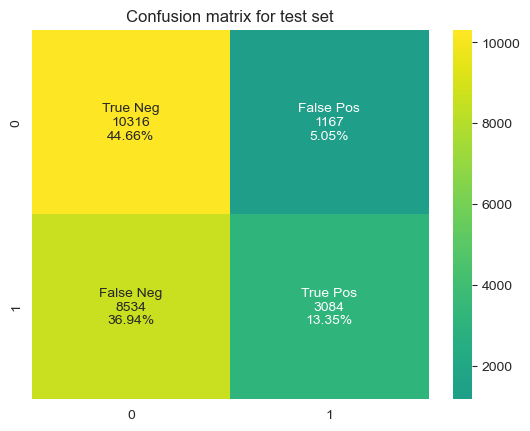

Fold 2:
Accuracy:  0.58775
Precision:  0.72796
Recall:  0.2761
F1 score:  0.40035


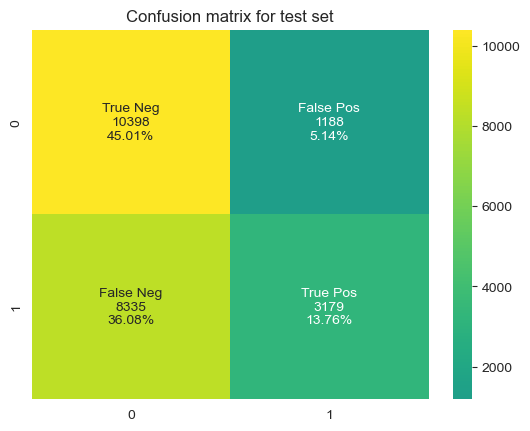

Fold 3:
Accuracy:  0.6042
Precision:  0.71418
Recall:  0.34056
F1 score:  0.46119


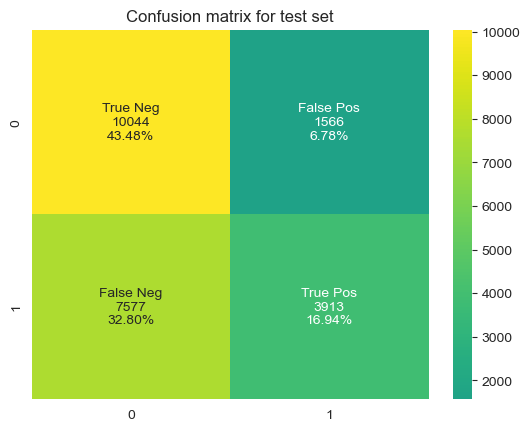

-------------------- Average results (3 folds)  --------------------
Average accuracy: 0.59067
Average precision: 0.72254
Average recall: 0.29404
Average f1 score: 0.41674


In [95]:
result = simulate_cross_validation(X, y, k=3)

In [96]:
results_cross_validation.update_results("Cross validation", "3", result[0], result[1], result[2], result[3])

Fold 1:
Accuracy:  0.58692
Precision:  0.72156
Recall:  0.28448
F1 score:  0.40807


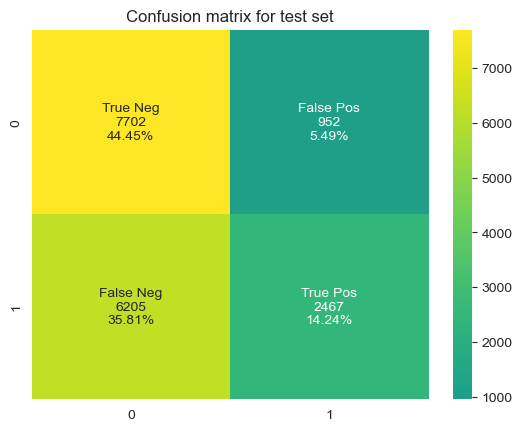

Fold 2:
Accuracy:  0.58257
Precision:  0.71589
Recall:  0.27833
F1 score:  0.40083


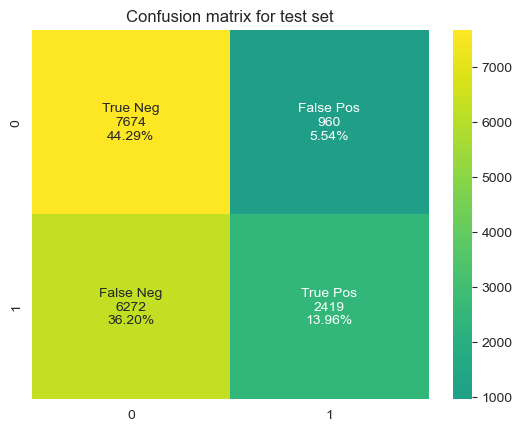

Fold 3:
Accuracy:  0.59111
Precision:  0.73853
Recall:  0.28552
F1 score:  0.41182


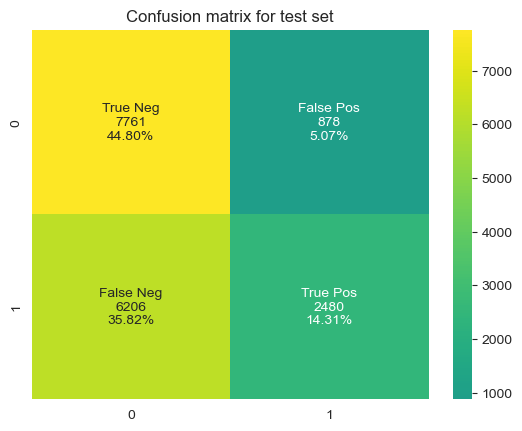

Fold 4:
Accuracy:  0.60202
Precision:  0.7177
Recall:  0.32264
F1 score:  0.44516


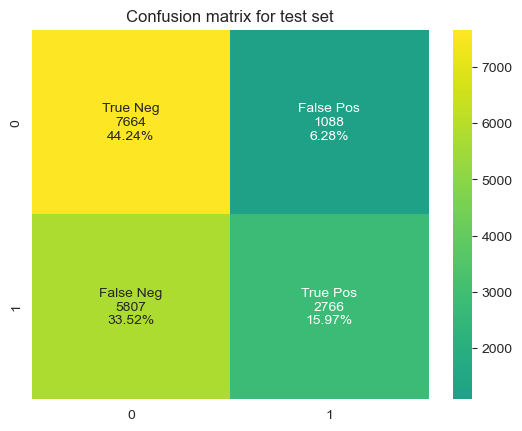

-------------------- Average results (4 folds)  --------------------
Average accuracy: 0.59066
Average precision: 0.72342
Average recall: 0.29274
Average f1 score: 0.41647


In [97]:
result = simulate_cross_validation(X, y, k=4)

In [98]:
results_cross_validation.update_results("Cross validation", "4", result[0], result[1], result[2], result[3])

Fold 1:
Accuracy:  0.58315
Precision:  0.72077
Recall:  0.27057
F1 score:  0.39345


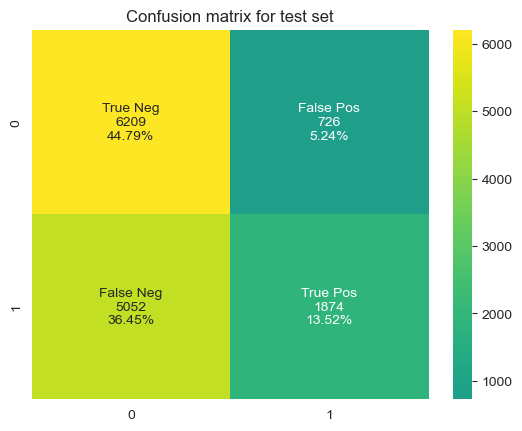

Fold 2:
Accuracy:  0.58463
Precision:  0.72277
Recall:  0.28424
F1 score:  0.40802


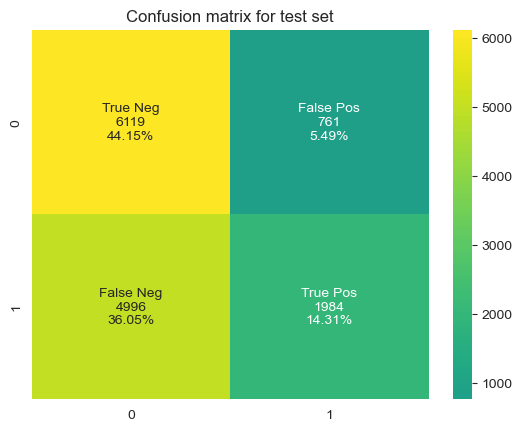

Fold 3:
Accuracy:  0.58918
Precision:  0.71621
Recall:  0.30457
F1 score:  0.42739


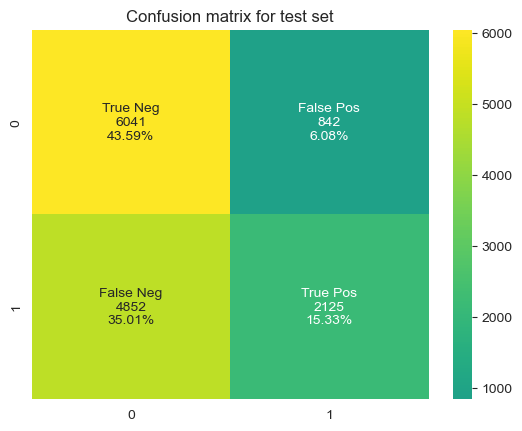

Fold 4:
Accuracy:  0.59567
Precision:  0.73377
Recall:  0.29219
F1 score:  0.41795


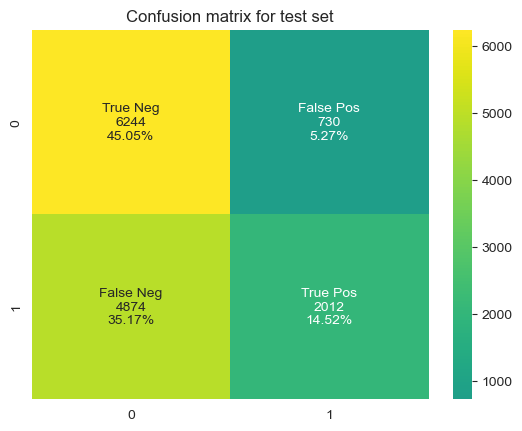

Fold 5:
Accuracy:  0.59726
Precision:  0.71861
Recall:  0.30483
F1 score:  0.42807


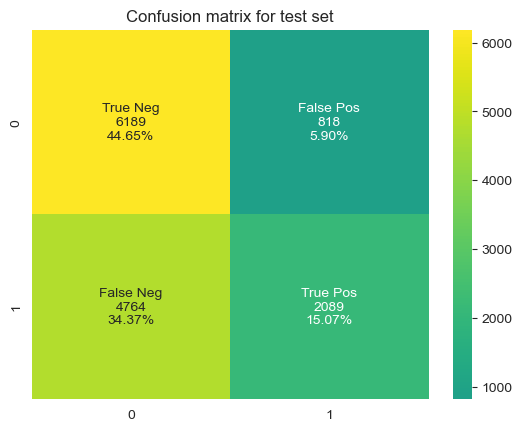

-------------------- Average results (5 folds)  --------------------
Average accuracy: 0.58998
Average precision: 0.72243
Average recall: 0.29128
Average f1 score: 0.41498


In [99]:
result = simulate_cross_validation(X, y, k=5)

In [100]:
results_cross_validation.update_results("Cross validation", "5", result[0], result[1], result[2], result[3])

Fold 1:
Accuracy:  0.5861
Precision:  0.71779
Recall:  0.27961
F1 score:  0.40245


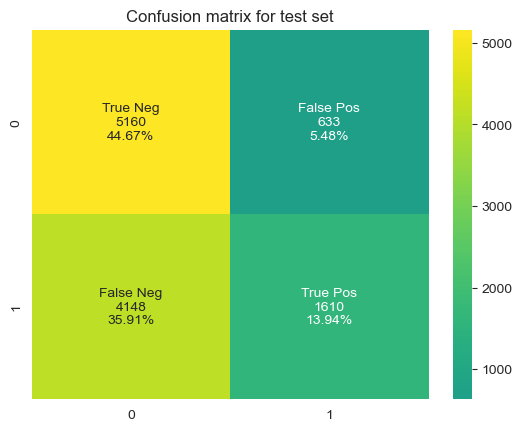

Fold 2:
Accuracy:  0.58208
Precision:  0.72466
Recall:  0.2843
F1 score:  0.40838


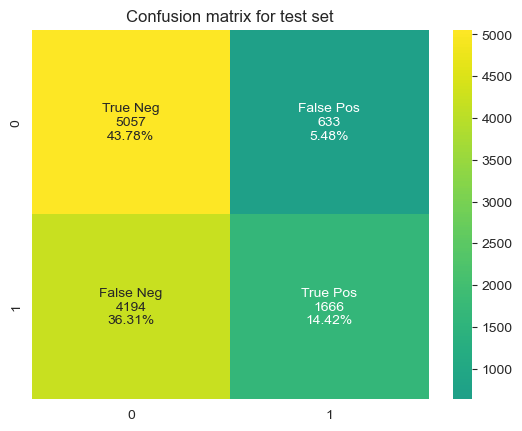

Fold 3:
Accuracy:  0.58701
Precision:  0.70968
Recall:  0.28721
F1 score:  0.40892


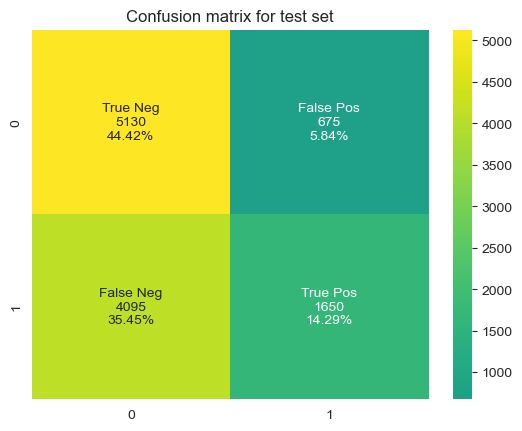

Fold 4:
Accuracy:  0.59212
Precision:  0.74133
Recall:  0.28168
F1 score:  0.40824


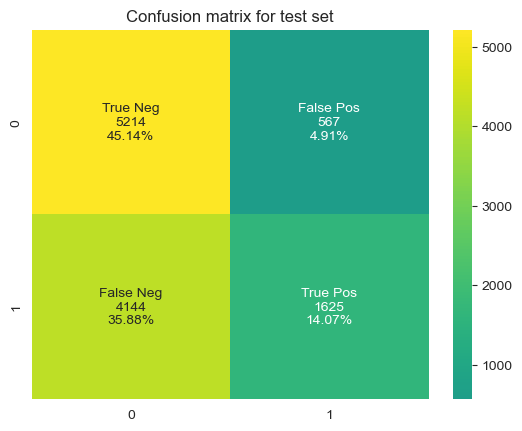

Fold 5:
Accuracy:  0.59506
Precision:  0.72316
Recall:  0.31169
F1 score:  0.43562


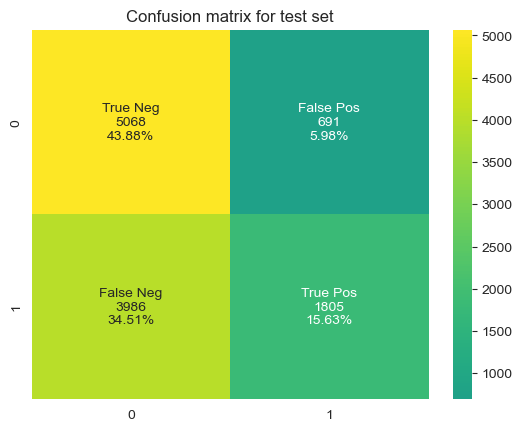

Fold 6:
Accuracy:  0.59879
Precision:  0.72013
Recall:  0.30567
F1 score:  0.42917


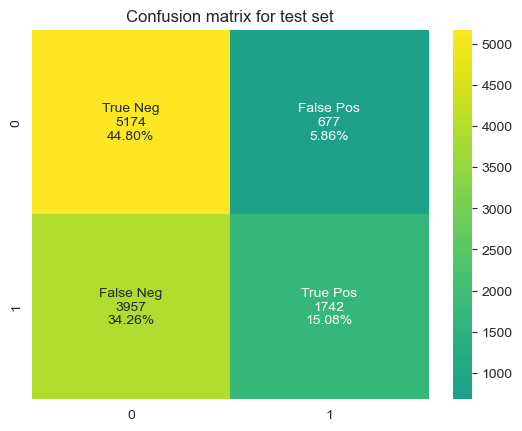

-------------------- Average results (6 folds)  --------------------
Average accuracy: 0.59019
Average precision: 0.72279
Average recall: 0.29169
Average f1 score: 0.41546


In [101]:
result = simulate_cross_validation(X, y, k=6)

In [102]:
results_cross_validation.update_results("Cross validation", "6", result[0], result[1], result[2], result[3])

Fold 1:
Accuracy:  0.58267
Precision:  0.71466
Recall:  0.27649
F1 score:  0.39872


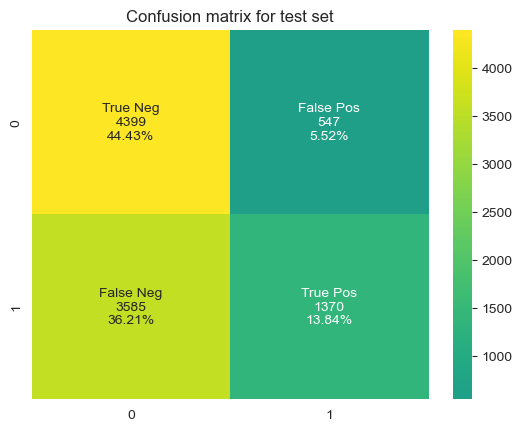

Fold 2:
Accuracy:  0.58576
Precision:  0.71499
Recall:  0.2924
F1 score:  0.41506


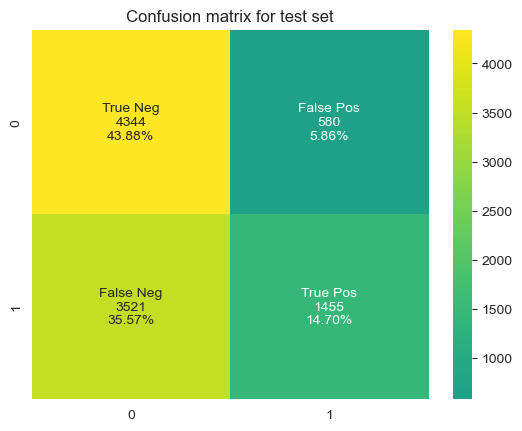

Fold 3:
Accuracy:  0.58697
Precision:  0.72595
Recall:  0.28157
F1 score:  0.40575


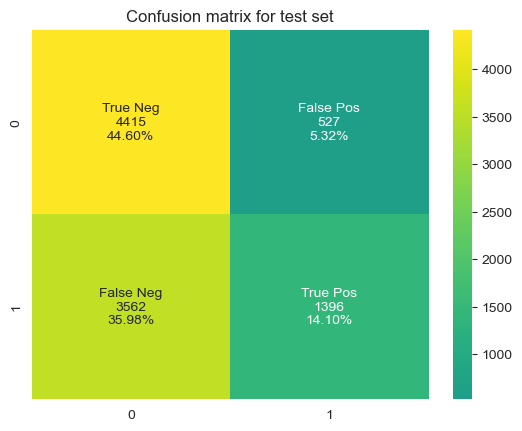

Fold 4:
Accuracy:  0.58667
Precision:  0.71279
Recall:  0.29976
F1 score:  0.42203


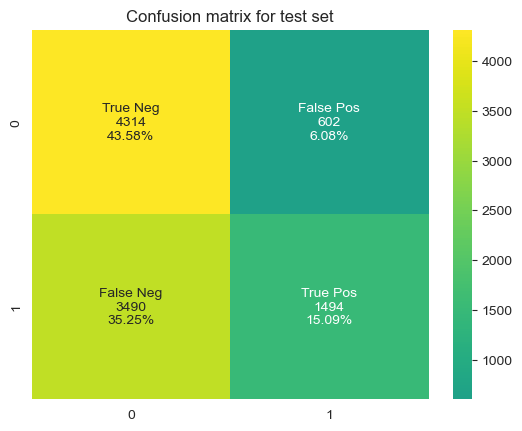

Fold 5:
Accuracy:  0.59313
Precision:  0.74334
Recall:  0.27768
F1 score:  0.40432


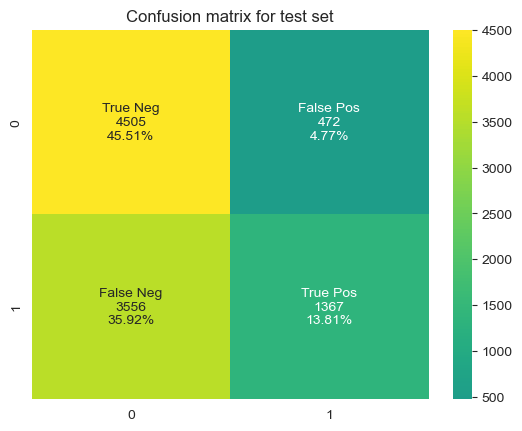

Fold 6:
Accuracy:  0.59475
Precision:  0.72115
Recall:  0.30923
F1 score:  0.43285


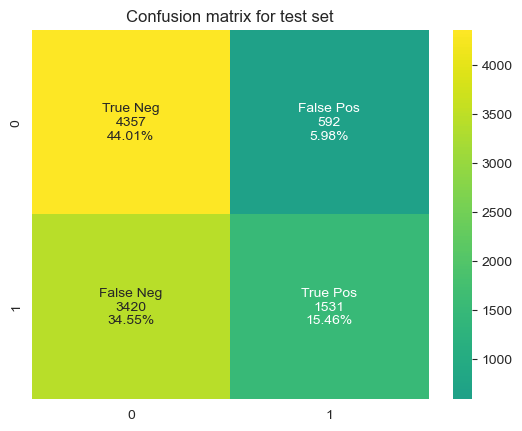

Fold 7:
Accuracy:  0.5998
Precision:  0.71979
Recall:  0.30667
F1 score:  0.43009


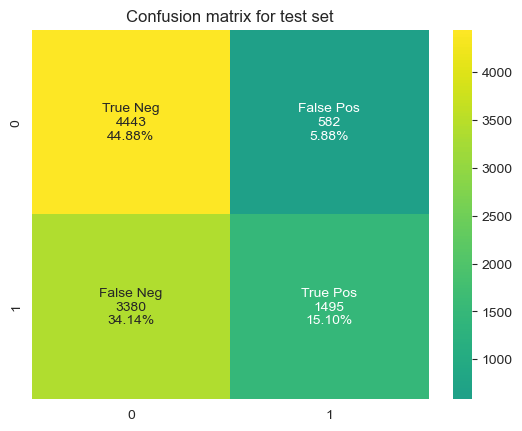

-------------------- Average results (7 folds)  --------------------
Average accuracy: 0.58996
Average precision: 0.72181
Average recall: 0.29197
Average f1 score: 0.41555


In [103]:
result = simulate_cross_validation(X, y, k=7)

In [104]:
results_cross_validation.update_results("Cross validation", "7", result[0], result[1], result[2], result[3])

Fold 1:
Accuracy:  0.58444
Precision:  0.71062
Recall:  0.27659
F1 score:  0.39819


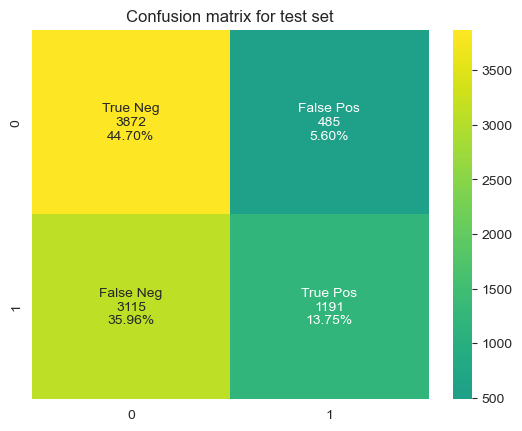

Fold 2:
Accuracy:  0.58871
Precision:  0.71785
Recall:  0.30302
F1 score:  0.42616


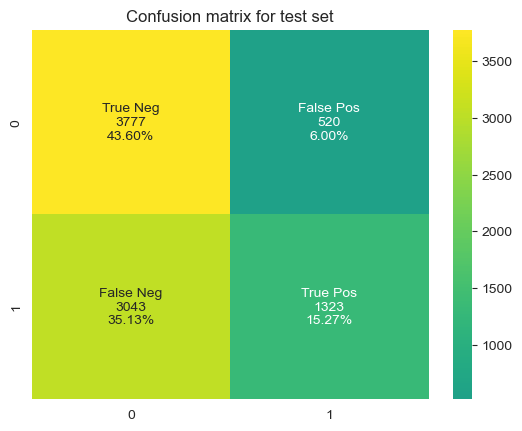

Fold 3:
Accuracy:  0.57867
Precision:  0.72181
Recall:  0.26932
F1 score:  0.39227


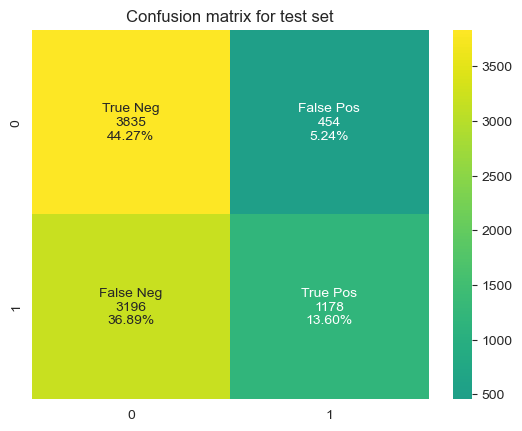

Fold 4:
Accuracy:  0.58756
Precision:  0.70845
Recall:  0.29319
F1 score:  0.41474


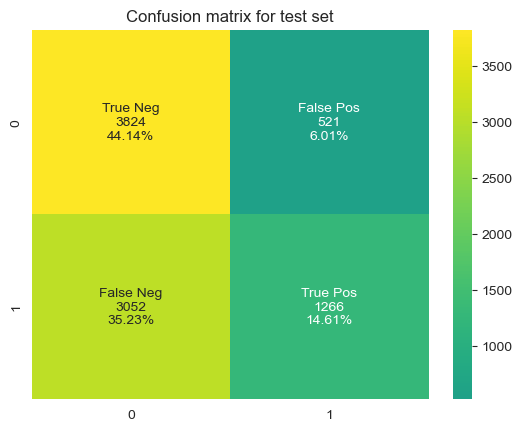

Fold 5:
Accuracy:  0.59448
Precision:  0.72783
Recall:  0.30288
F1 score:  0.42776


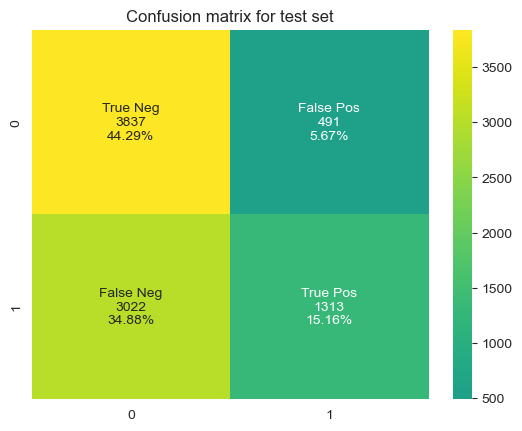

Fold 6:
Accuracy:  0.58901
Precision:  0.73697
Recall:  0.28269
F1 score:  0.40864


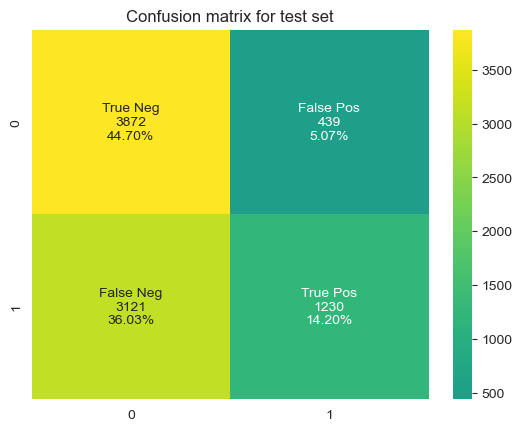

Fold 7:
Accuracy:  0.59351
Precision:  0.72113
Recall:  0.29726
F1 score:  0.42098


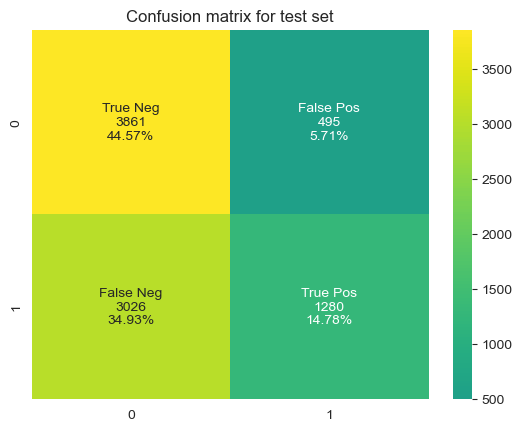

Fold 8:
Accuracy:  0.60102
Precision:  0.72011
Recall:  0.3106
F1 score:  0.434


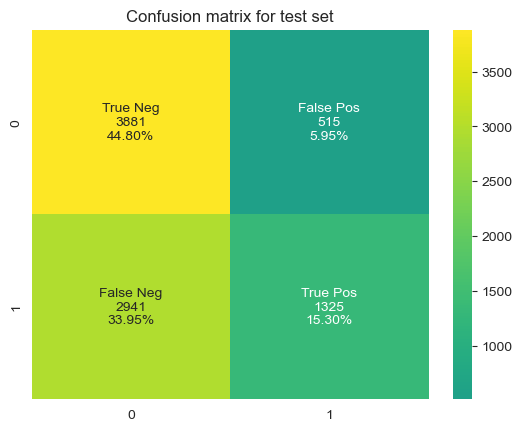

-------------------- Average results (8 folds)  --------------------
Average accuracy: 0.58967
Average precision: 0.7206
Average recall: 0.29194
Average f1 score: 0.41534


In [105]:
result = simulate_cross_validation(X, y, k=8)

In [106]:
results_cross_validation.update_results("Cross validation", "8", result[0], result[1], result[2], result[3])

Fold 1:
Accuracy:  0.58772
Precision:  0.70217
Recall:  0.30335
F1 score:  0.42367


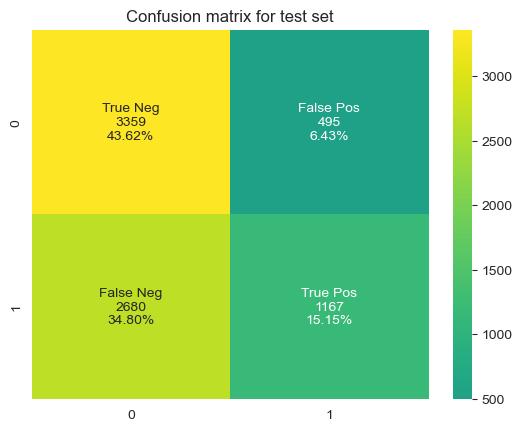

Fold 2:
Accuracy:  0.58429
Precision:  0.7265
Recall:  0.26757
F1 score:  0.3911


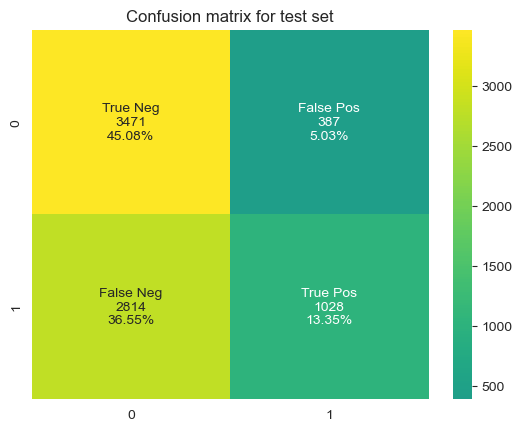

Fold 3:
Accuracy:  0.58156
Precision:  0.7253
Recall:  0.28964
F1 score:  0.41397


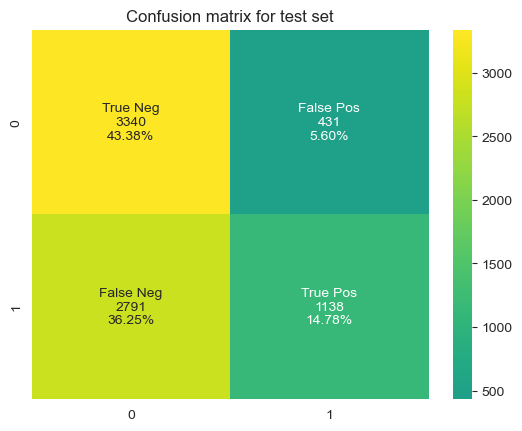

Fold 4:
Accuracy:  0.58675
Precision:  0.71543
Recall:  0.28094
F1 score:  0.40345


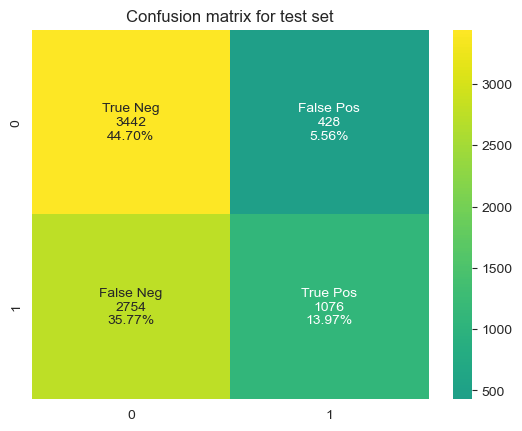

Fold 5:
Accuracy:  0.58818
Precision:  0.71411
Recall:  0.29979
F1 score:  0.4223


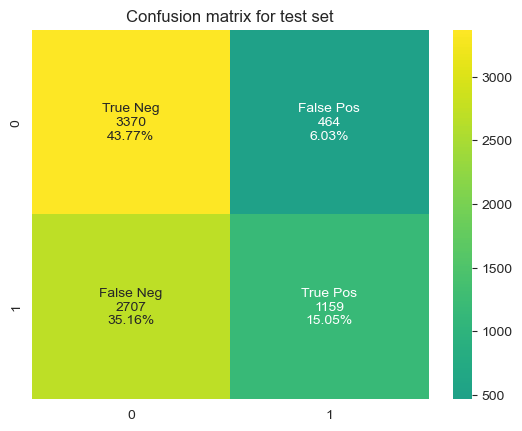

Fold 6:
Accuracy:  0.59429
Precision:  0.74198
Recall:  0.27868
F1 score:  0.40518


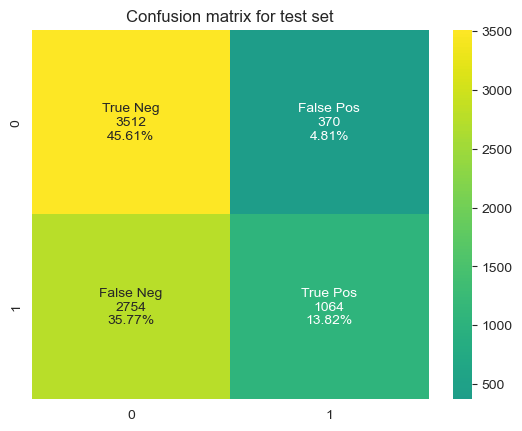

Fold 7:
Accuracy:  0.5961
Precision:  0.72445
Recall:  0.31391
F1 score:  0.43802


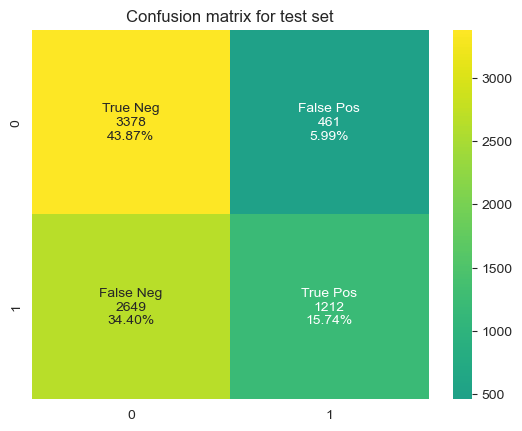

Fold 8:
Accuracy:  0.59299
Precision:  0.72668
Recall:  0.28923
F1 score:  0.41377


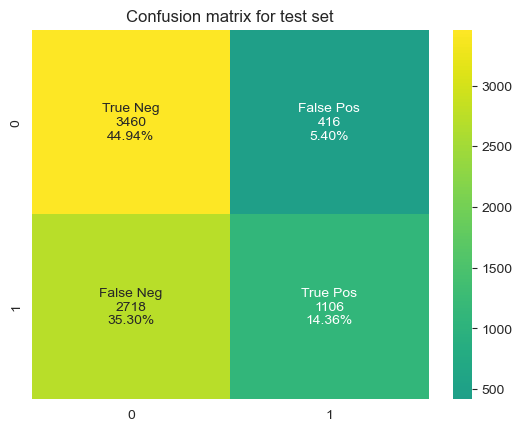

Fold 9:
Accuracy:  0.59818
Precision:  0.71796
Recall:  0.30775
F1 score:  0.43083


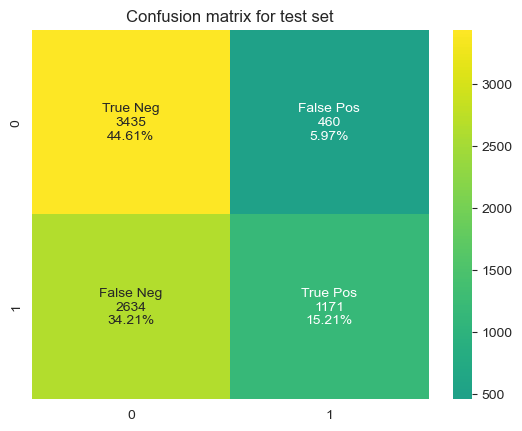

-------------------- Average results (9 folds)  --------------------
Average accuracy: 0.59001
Average precision: 0.72162
Average recall: 0.29232
Average f1 score: 0.41581


In [107]:
result = simulate_cross_validation(X, y, k=9)

In [108]:
results_cross_validation.update_results("Cross validation", "9", result[0], result[1], result[2], result[3])

Fold 1:
Accuracy:  0.58505
Precision:  0.69591
Recall:  0.3002
F1 score:  0.41946


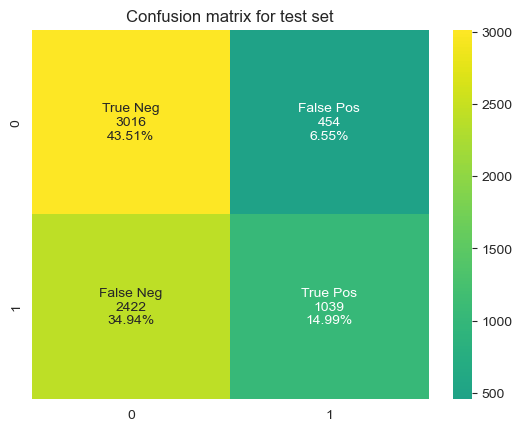

Fold 2:
Accuracy:  0.58543
Precision:  0.73455
Recall:  0.26753
F1 score:  0.39221


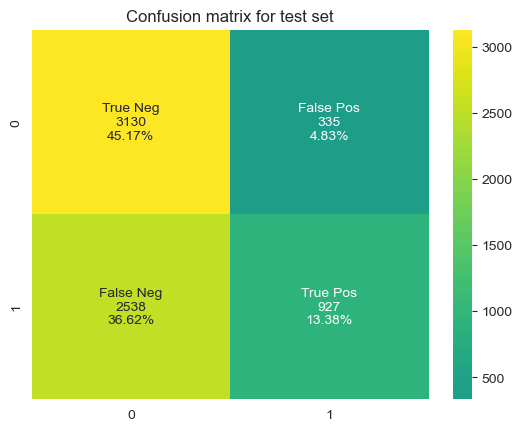

Fold 3:
Accuracy:  0.58543
Precision:  0.71409
Recall:  0.29602
F1 score:  0.41854


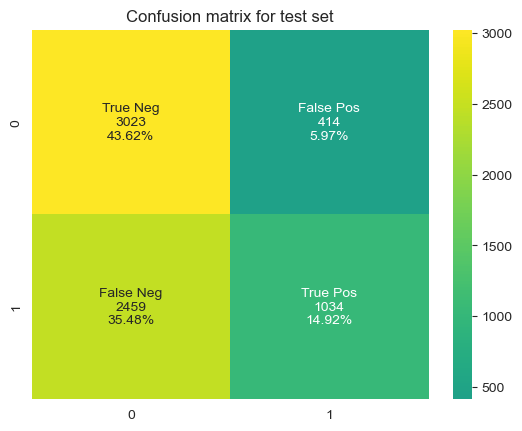

Fold 4:
Accuracy:  0.58658
Precision:  0.73278
Recall:  0.28076
F1 score:  0.40597


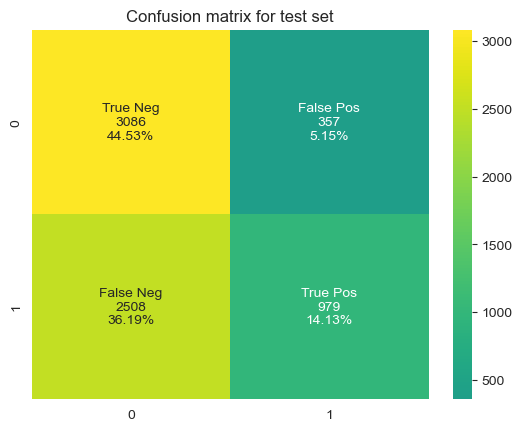

Fold 5:
Accuracy:  0.58355
Precision:  0.69923
Recall:  0.28985
F1 score:  0.40982


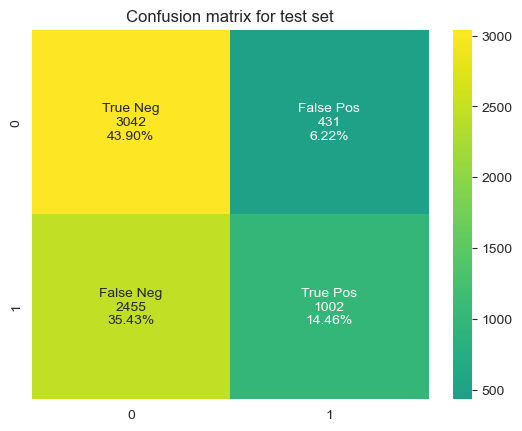

Fold 6:
Accuracy:  0.59149
Precision:  0.73419
Recall:  0.30682
F1 score:  0.43278


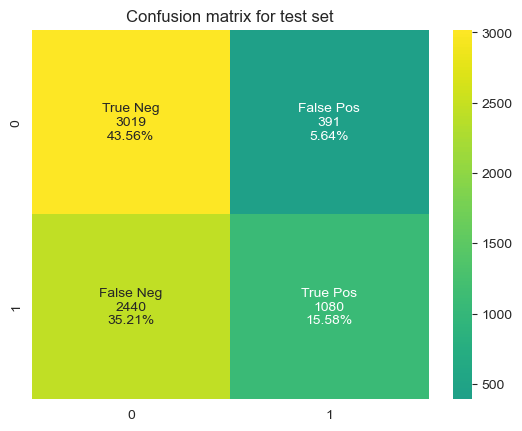

Fold 7:
Accuracy:  0.60115
Precision:  0.74259
Recall:  0.28116
F1 score:  0.40788


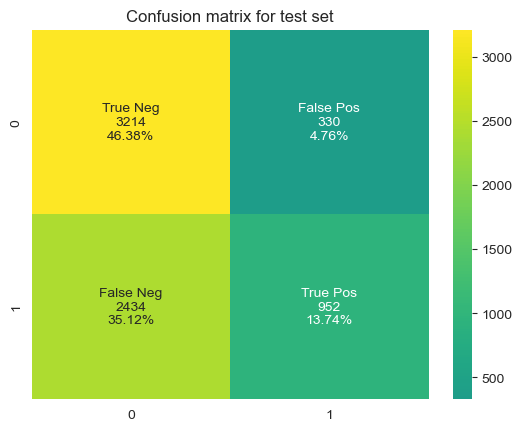

Fold 8:
Accuracy:  0.59221
Precision:  0.72407
Recall:  0.31114
F1 score:  0.43525


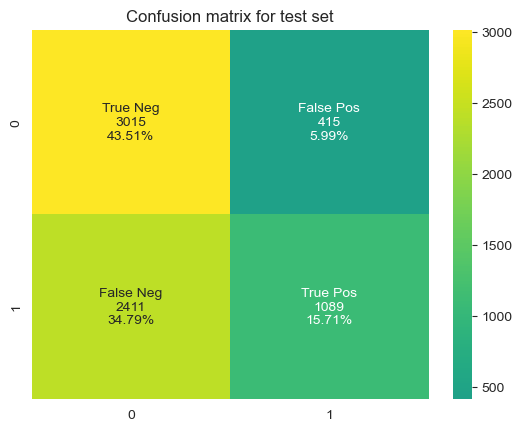

Fold 9:
Accuracy:  0.59654
Precision:  0.7311
Recall:  0.29312
F1 score:  0.41847


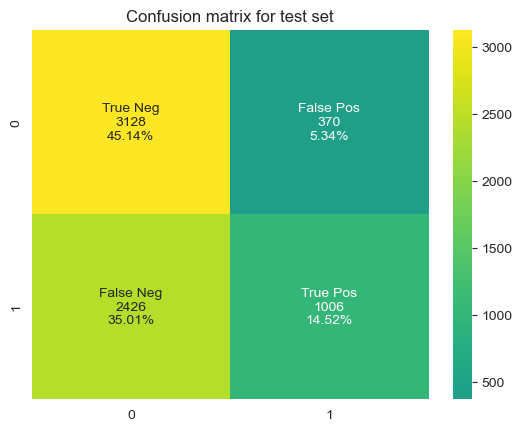

Fold 10:
Accuracy:  0.59524
Precision:  0.71241
Recall:  0.30196
F1 score:  0.42414


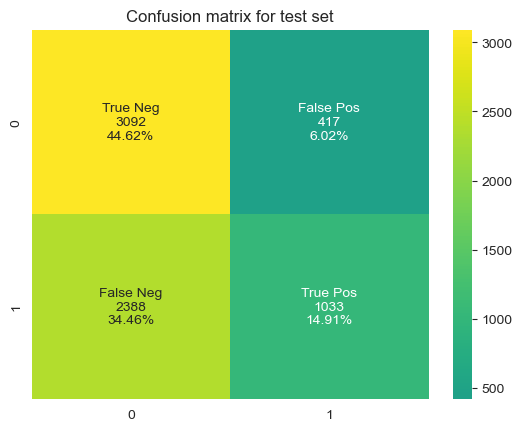

-------------------- Average results (10 folds)  --------------------
Average accuracy: 0.59027
Average precision: 0.72209
Average recall: 0.29286
Average f1 score: 0.41645


In [109]:
result = simulate_cross_validation(X, y, k=10)

In [110]:
results_cross_validation.update_results("Cross validation", "10", result[0], result[1], result[2], result[3])

Fold 1:
Accuracy:  0.57934
Precision:  0.70157
Recall:  0.30351
F1 score:  0.42372


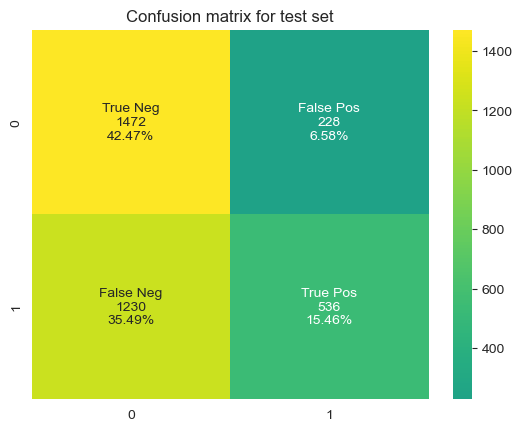

Fold 2:
Accuracy:  0.58672
Precision:  0.686
Recall:  0.28614
F1 score:  0.40383


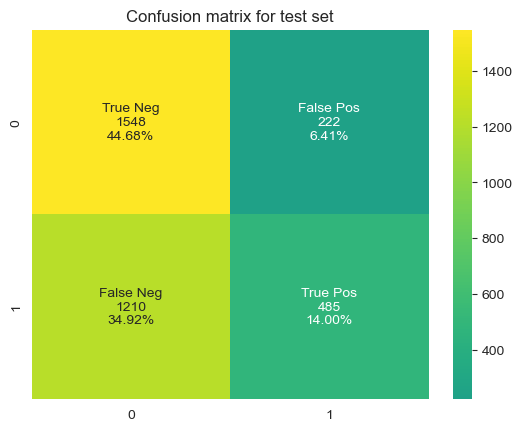

Fold 3:
Accuracy:  0.5899
Precision:  0.73692
Recall:  0.27704
F1 score:  0.40269


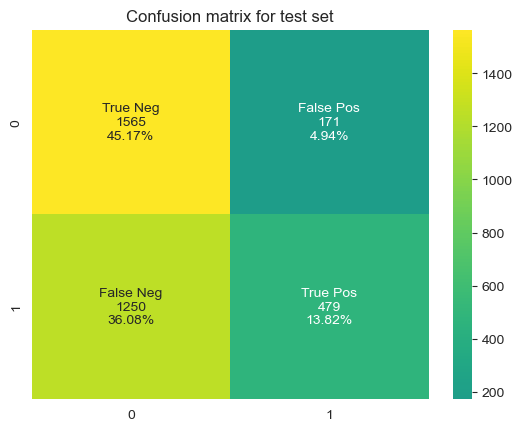

Fold 4:
Accuracy:  0.58817
Precision:  0.7223
Recall:  0.28917
F1 score:  0.413


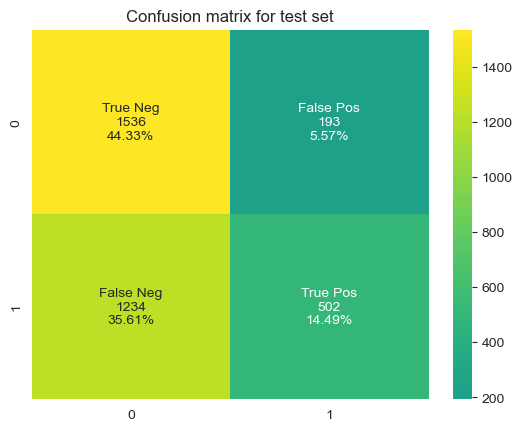

Fold 5:
Accuracy:  0.58701
Precision:  0.70916
Recall:  0.30584
F1 score:  0.42737


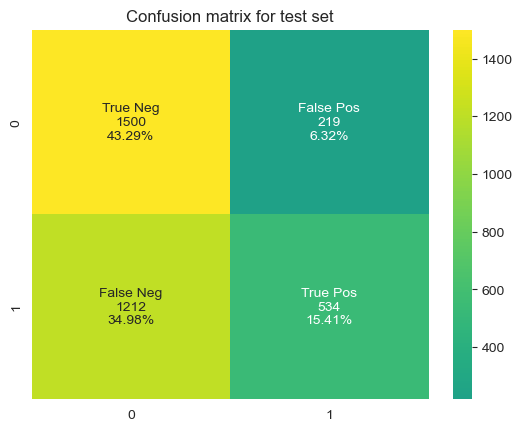

Fold 6:
Accuracy:  0.5798
Precision:  0.71241
Recall:  0.27934
F1 score:  0.40132


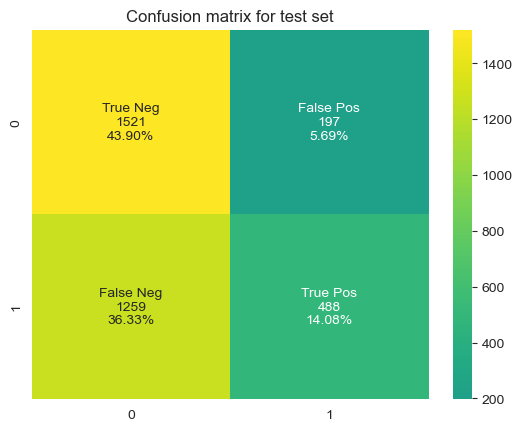

Fold 7:
Accuracy:  0.5824
Precision:  0.72984
Recall:  0.2912
F1 score:  0.4163


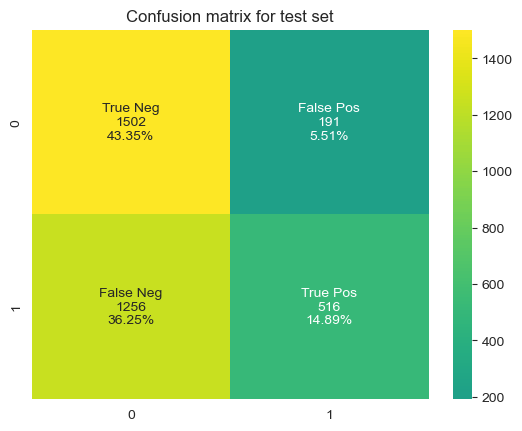

Fold 8:
Accuracy:  0.59192
Precision:  0.73406
Recall:  0.27522
F1 score:  0.40034


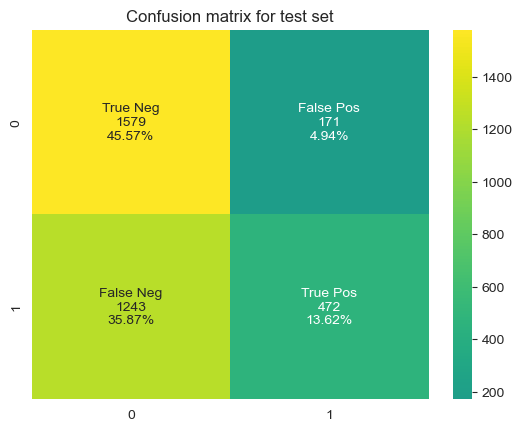

Fold 9:
Accuracy:  0.58413
Precision:  0.70638
Recall:  0.28753
F1 score:  0.4087


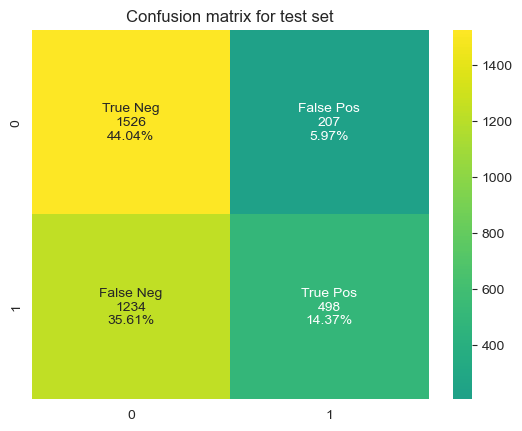

Fold 10:
Accuracy:  0.58297
Precision:  0.6983
Recall:  0.2858
F1 score:  0.40559


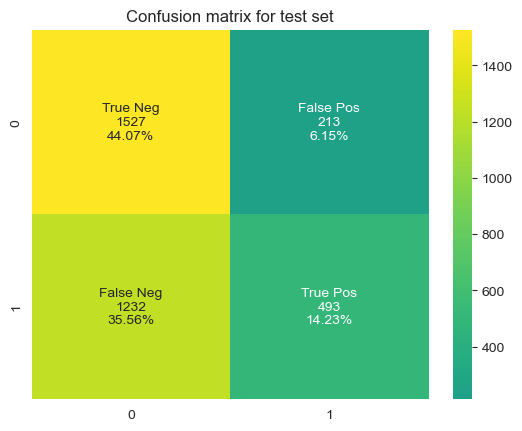

Fold 11:
Accuracy:  0.59076
Precision:  0.73315
Recall:  0.29829
F1 score:  0.42405


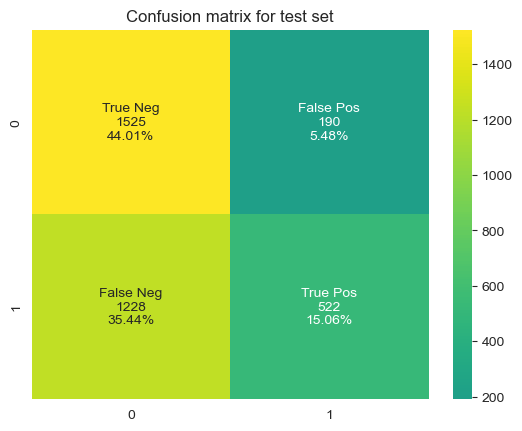

Fold 12:
Accuracy:  0.5899
Precision:  0.7336
Recall:  0.3096
F1 score:  0.43544


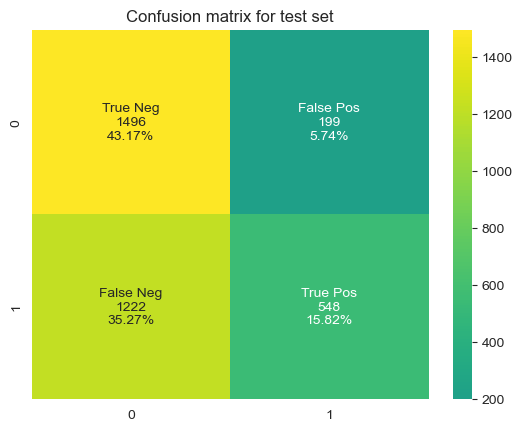

Fold 13:
Accuracy:  0.60606
Precision:  0.75279
Recall:  0.28062
F1 score:  0.40883


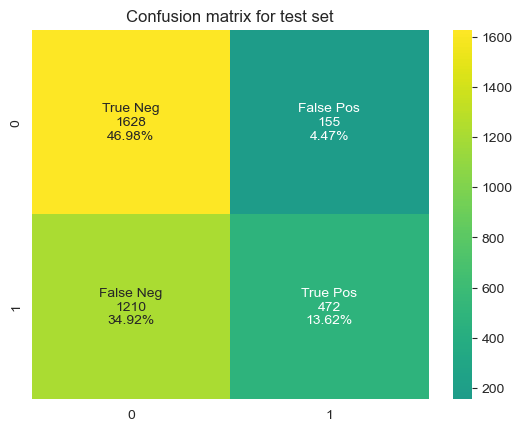

Fold 14:
Accuracy:  0.60404
Precision:  0.73184
Recall:  0.30751
F1 score:  0.43306


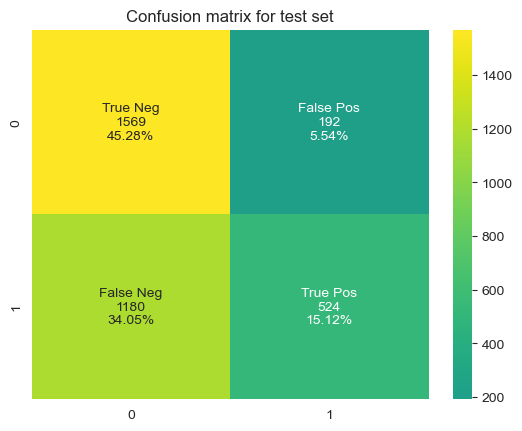

Fold 15:
Accuracy:  0.5798
Precision:  0.72563
Recall:  0.2927
F1 score:  0.41713


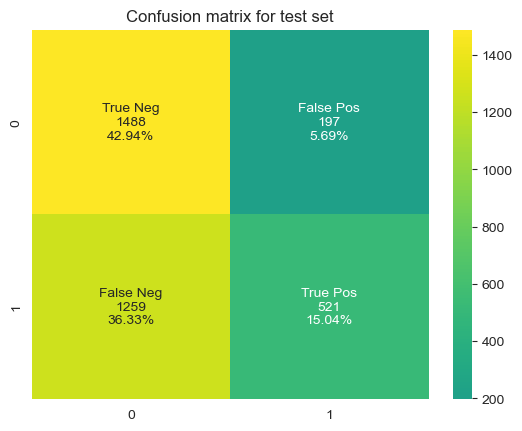

Fold 16:
Accuracy:  0.59711
Precision:  0.72192
Recall:  0.3064
F1 score:  0.4302


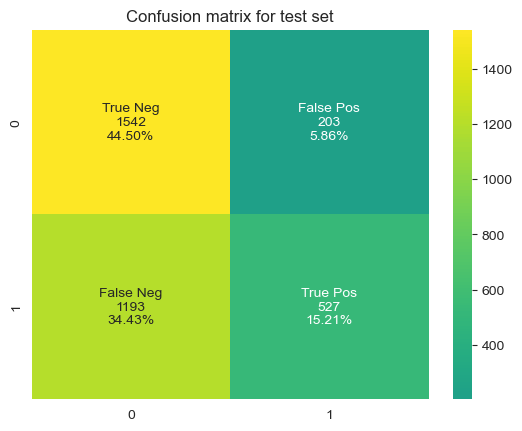

Fold 17:
Accuracy:  0.59019
Precision:  0.73088
Recall:  0.28662
F1 score:  0.41176


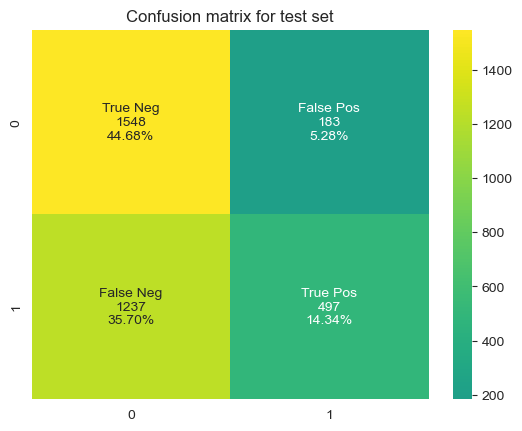

Fold 18:
Accuracy:  0.60289
Precision:  0.73333
Recall:  0.298
F1 score:  0.42379


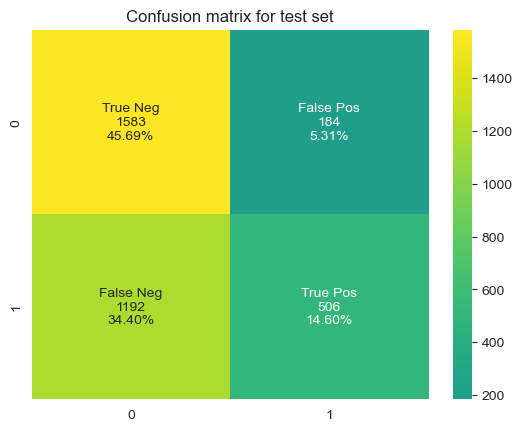

Fold 19:
Accuracy:  0.60924
Precision:  0.7256
Recall:  0.30663
F1 score:  0.43109


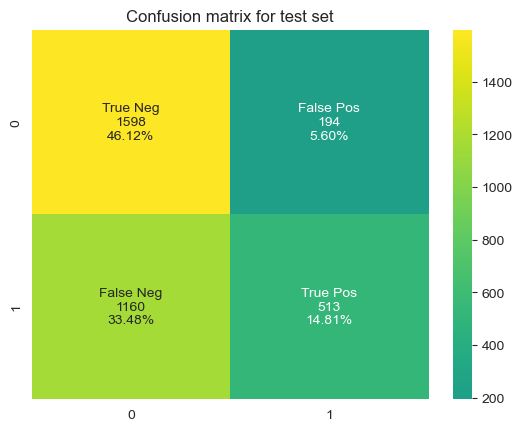

Fold 20:
Accuracy:  0.58038
Precision:  0.70531
Recall:  0.2889
F1 score:  0.4099


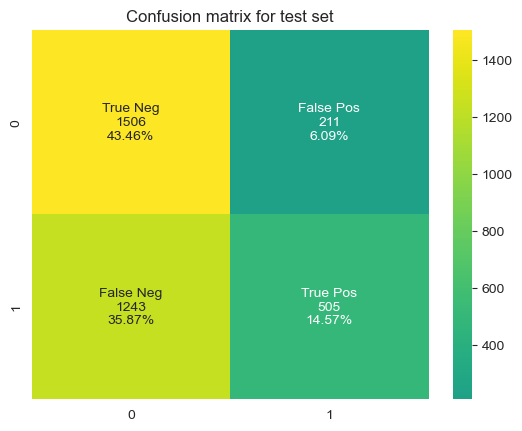

-------------------- Average results (20 folds)  --------------------
Average accuracy: 0.59014
Average precision: 0.72155
Average recall: 0.2928
Average f1 score: 0.41641


In [111]:
result = simulate_cross_validation(X, y, k=20)

In [112]:
results_cross_validation.update_results("Cross validation", "20", result[0], result[1], result[2], result[3])

In [113]:
results_standard.sort_results("Sets size (training|validation|test) / Folds number")
results_cross_validation.results

,Type,Sets size (training|validation|test) / Folds number,Accuracy,Precision,Recall,F1 score
0,Cross validation,3,0.59067,0.72254,0.29404,0.41674
1,Cross validation,4,0.59066,0.72342,0.29274,0.41647
2,Cross validation,5,0.58998,0.72243,0.29128,0.41498
3,Cross validation,6,0.59019,0.72279,0.29169,0.41546
4,Cross validation,7,0.58996,0.72181,0.29197,0.41555
5,Cross validation,8,0.58967,0.72060,0.29194,0.41534
6,Cross validation,9,0.59001,0.72162,0.29232,0.41581
7,Cross validation,10,0.59027,0.72209,0.29286,0.41645
8,Cross validation,20,0.59014,0.72155,0.29280,0.41641


## 5. Podsumowanie

In [114]:
results = pd.concat([results_standard.results, results_cross_validation.results])

In [115]:
results

,Type,Sets size (training|validation|test) / Folds number,Accuracy,Precision,Recall,F1 score
0,Standard,"0,6 | 0,2 | 0,2",0.57947,0.72139,0.25765,0.37970
1,Standard,"0,7 | 0,15 | 0,15",0.58042,0.72080,0.26933,0.39214
2,Standard,"0,8 | 0,1 | 0,1",0.58419,0.71820,0.27294,0.39555
3,Standard,"0,9 | 0,05 | 0,05",0.58223,0.69717,0.29753,0.41707
4,Standard,"0,95 | 0,025 | 0,025",0.58165,0.70604,0.30499,0.42597
0,Cross validation,3,0.59067,0.72254,0.29404,0.41674
1,Cross validation,4,0.59066,0.72342,0.29274,0.41647
2,Cross validation,5,0.58998,0.72243,0.29128,0.41498
3,Cross validation,6,0.59019,0.72279,0.29169,0.41546
4,Cross validation,7,0.58996,0.72181,0.29197,0.41555
